http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/

In [24]:
import os
import glob
import math

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 80)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, brier_score_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv("bank-dataset.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Análisis exploratorio de los datos

In [4]:
df.shape

(45211, 17)

In [5]:
binary_col_list = ['y', 'loan', 'housing', 'default']
df[binary_col_list].apply(lambda x: x.value_counts())

,y,loan,housing,default
no,39922,37967,20081,44396
yes,5289,7244,25130,815


In [6]:
df[binary_col_list] = df[binary_col_list].apply(lambda x: x.map(dict(yes=1, no=0)))
df[binary_col_list].apply(lambda x: x.value_counts())

,y,loan,housing,default
0,39922,37967,20081,44396
1,5289,7244,25130,815


In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [8]:
df.dtypes

age           int64
job          object
marital      object
education    object
default       int64
balance       int64
housing       int64
loan          int64
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [9]:
df.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


Variable **pdays**

In [10]:
df.loc[df.pdays == -1, 'pdays'].count() / len(df)

0.81736745482294137

El 81% de los registros de la variable **pdays** es -1, lo cual quiere decir que el cliente nunca fue contactado anteriormente. Por lo tanto, la variable **poutcome** tendrá el valor *unknown* un 81% de las veces, al igual que la variable **previous** con el valor 0.

In [72]:
print(df.loc[df.poutcome == 'unknown', 'poutcome'].count() / len(df))
print(df.loc[df.previous == 0, 'previous'].count() / len(df))

0.817478047378
0.817367454823


Se han de usar técnicas de balanceo de clases, dado que solo hay un 11% de la clase positiva.

In [12]:
null_data = df.isnull().mean()
null_data.sort_values(ascending=False)

y            0.0
loan         0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
contact      0.0
poutcome     0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
age          0.0
dtype: float64

In [13]:
corr = df.corr()
corr

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
age,1.000000,-0.017879,0.097783,-0.185513,-0.015655,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
default,-0.017879,1.000000,-0.066745,-0.006025,0.077234,0.009424,-0.010021,0.016822,-0.029979,-0.018329,-0.022419
balance,0.097783,-0.066745,1.000000,-0.068768,-0.084350,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
housing,-0.185513,-0.006025,-0.068768,1.000000,0.041323,-0.027982,0.005075,-0.023599,0.124178,0.037076,-0.139173
loan,-0.015655,0.077234,-0.084350,0.041323,1.000000,0.011370,-0.012412,0.009980,-0.022754,-0.011043,-0.068185
day,-0.009120,0.009424,0.004503,-0.027982,0.011370,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,-0.029979,0.003435,0.124178,-0.022754,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,-0.018329,0.016674,0.037076,-0.011043,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236


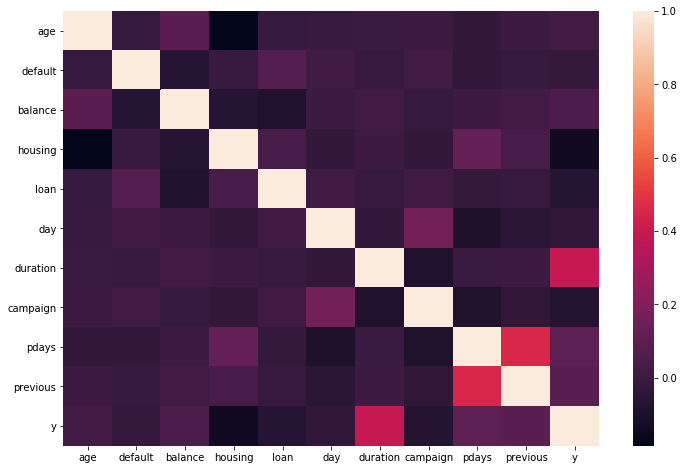

In [81]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Análisis de las variables continuas

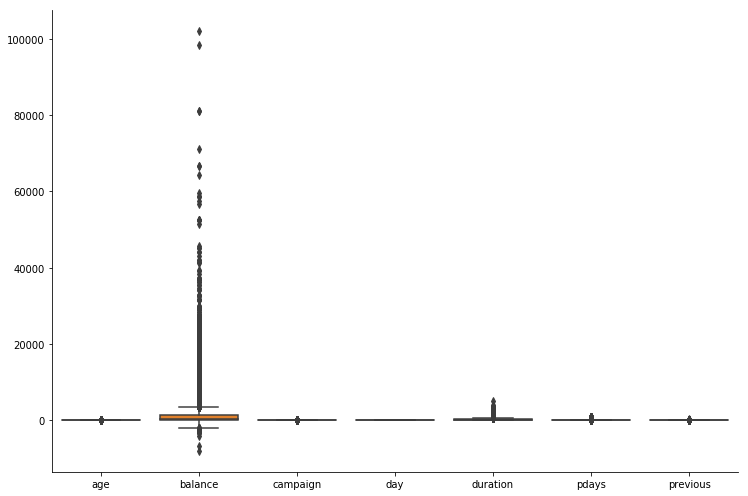

In [15]:
binary_col_list = ['y', 'loan', 'housing', 'default']

sns.factorplot(kind='box',
               data=df.loc[:, df.columns.difference(binary_col_list)],
               size=7,
               aspect=1.5,
               legend_out=False)

## Balance

In [16]:
df[['balance', 'y']].groupby('y').describe()

balance                                                                  
     count         mean          std     min    25%    50%     75%       max
y                                                                           
0  39922.0  1303.714969  2974.195473 -8019.0   58.0  417.0  1345.0  102127.0
1   5289.0  1804.267915  3501.104777 -3058.0  210.0  733.0  2159.0   81204.0

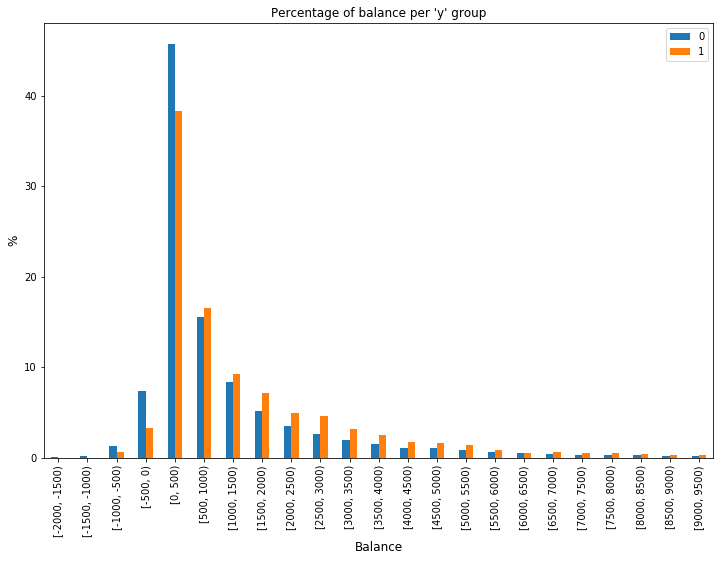

In [60]:
ranges =  [i for i in range(-2000, 10000, 500)]

temp = df[['balance', 'y']].groupby([pd.cut(df.balance, ranges, right=False), 'y']).count()
temp = temp.groupby(level=1).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', title ="Percentage of balance per 'y' group", legend=True)
ax.set_xlabel("Balance", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

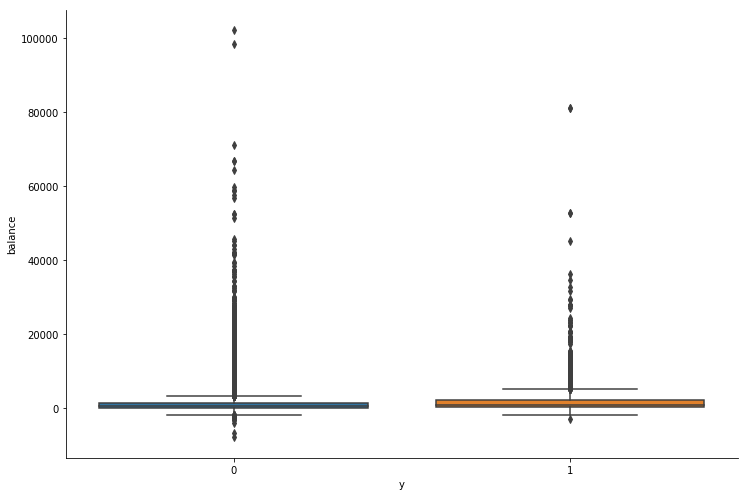

In [74]:
sns.factorplot(kind='box',
               x='y',
               y='balance',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

## Duration

In [19]:
df[['duration', 'y']].groupby('y').describe()

duration                                                          
     count        mean         std  min    25%    50%    75%     max
y                                                                   
0  39922.0  221.182806  207.383237  0.0   95.0  164.0  279.0  4918.0
1   5289.0  537.294574  392.525262  8.0  244.0  426.0  725.0  3881.0

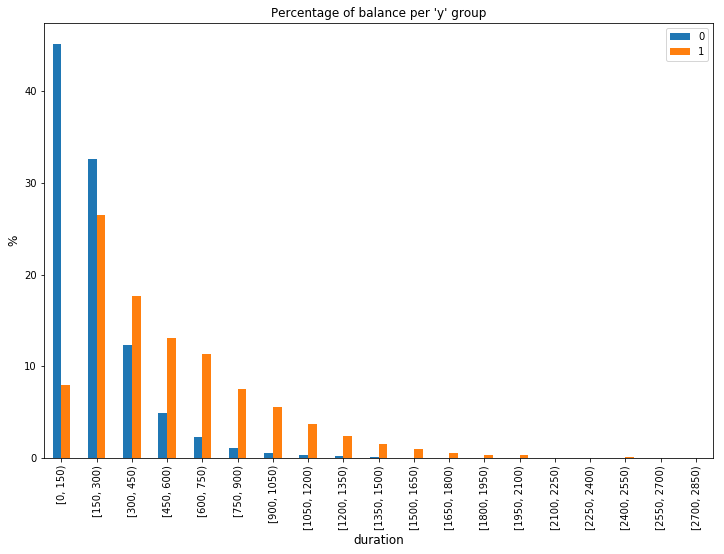

In [61]:
ranges =  [i for i in range(min(df.duration), 3000, 150)]

temp = df[['duration', 'y']].groupby([pd.cut(df.duration, ranges, right=False), 'y']).count()
temp = temp.groupby(level=1).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', title ="Percentage of balance per 'y' group", legend=True)
ax.set_xlabel("duration", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

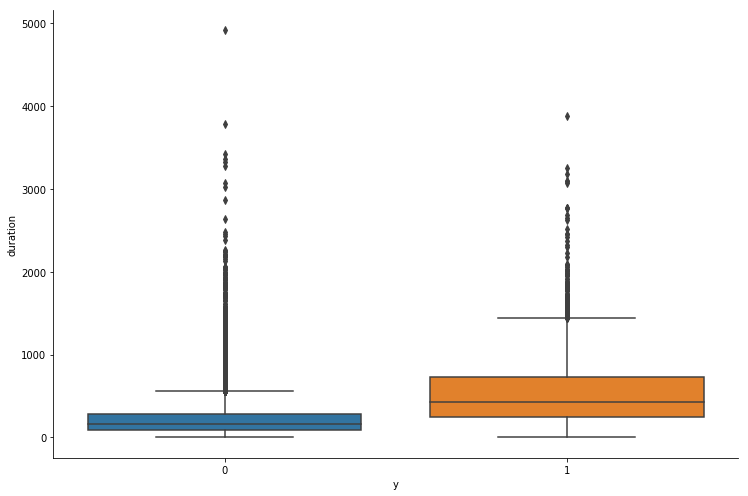

In [75]:
sns.factorplot(kind='box',
               x='y',
               y='duration',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

## pdays and previous

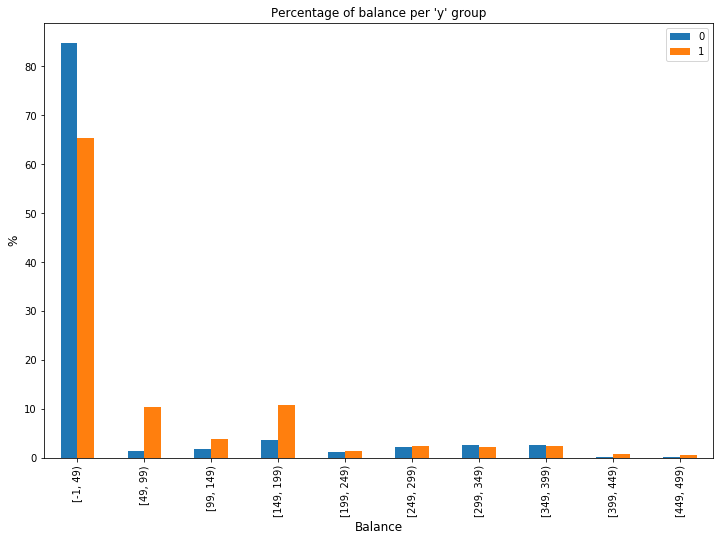

In [62]:
ranges =  [i for i in range(min(df.pdays), 500, 50)]

temp = df[['pdays', 'y']].groupby([pd.cut(df.pdays, ranges, right=False), 'y']).count()
temp = temp.groupby(level=1).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', title ="Percentage of balance per 'y' group", legend=True)
ax.set_xlabel("Balance", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

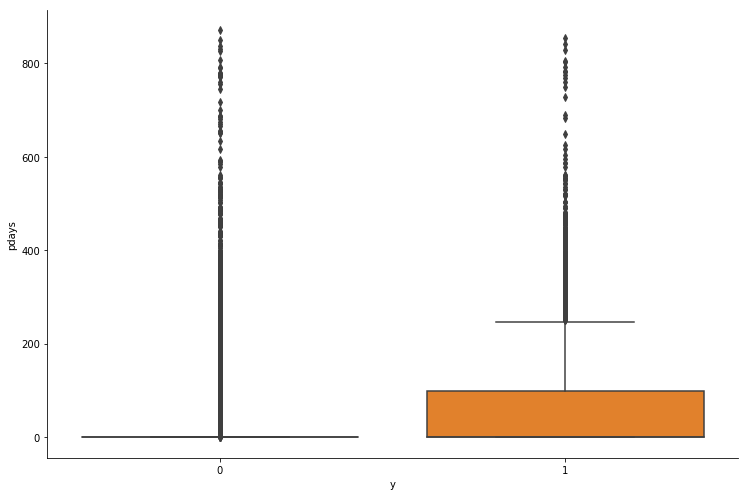

In [76]:
sns.factorplot(kind='box',
               x='y',
               y='pdays',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

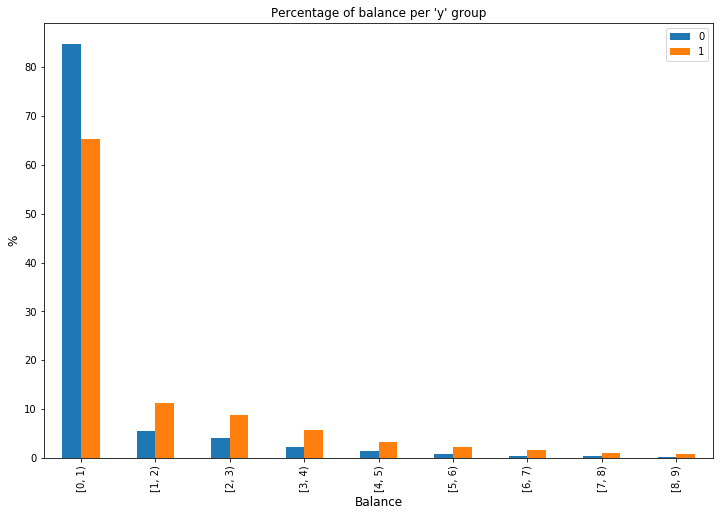

In [65]:
ranges =  [i for i in range(min(df.previous), 10, 1)]

temp = df[['previous', 'y']].groupby([pd.cut(df.previous, ranges, right=False), 'y']).count()
temp = temp.groupby(level=1).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', title ="Percentage of balance per 'y' group", legend=True)
ax.set_xlabel("Balance", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

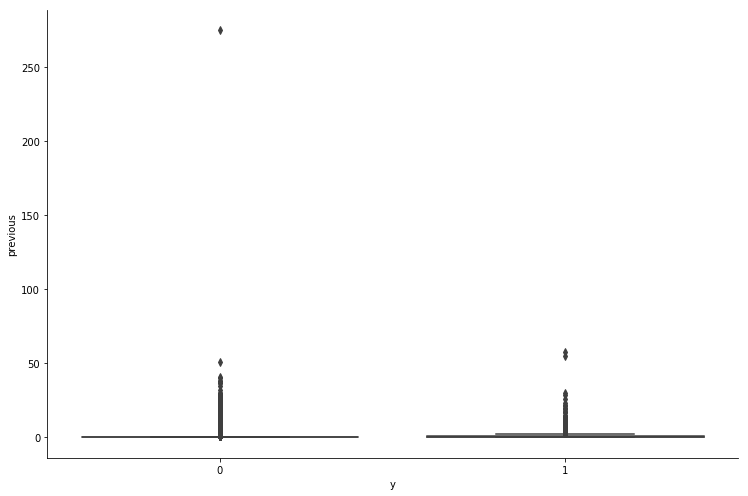

In [77]:
sns.factorplot(kind='box',
               x='y',
               y='previous',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

## campaign, day y age

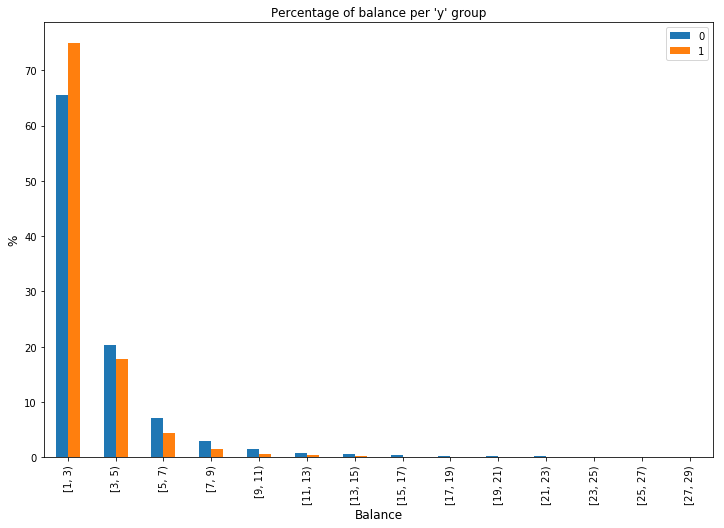

In [73]:
ranges =  [i for i in range(min(df.campaign), 30, 2)]

temp = df[['campaign', 'y']].groupby([pd.cut(df.campaign, ranges, right=False), 'y']).count()
temp = temp.groupby(level=1).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', title ="Percentage of balance per 'y' group", legend=True)
ax.set_xlabel("Balance", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

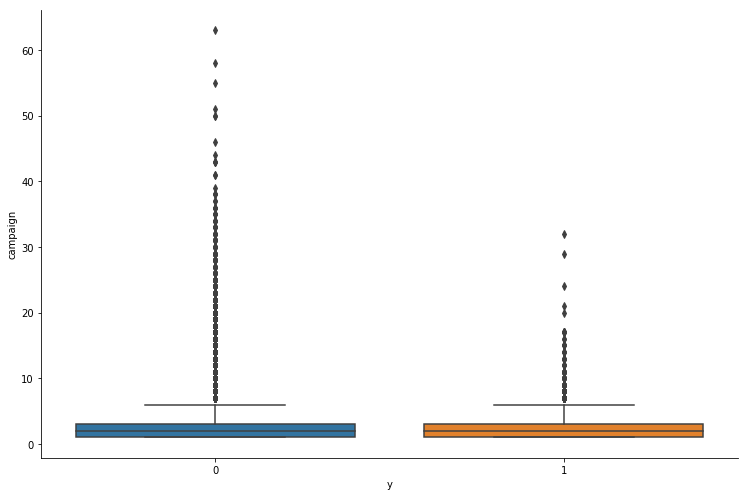

In [78]:
sns.factorplot(kind='box',
               x='y',
               y='campaign',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

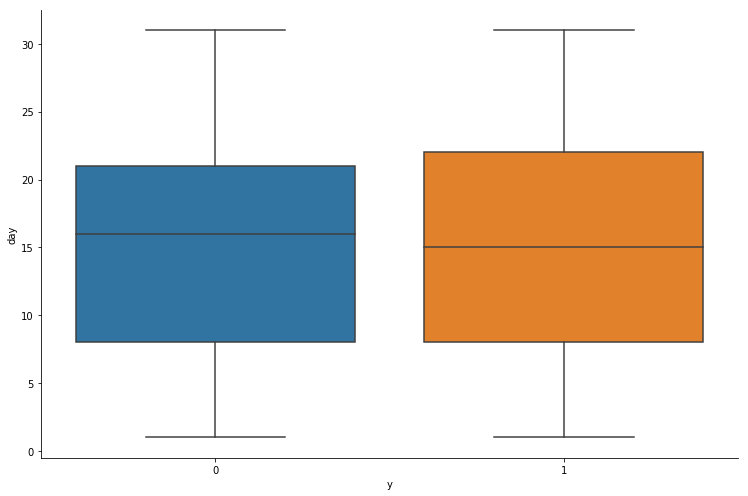

In [79]:
sns.factorplot(kind='box',
               x='y',
               y='day',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

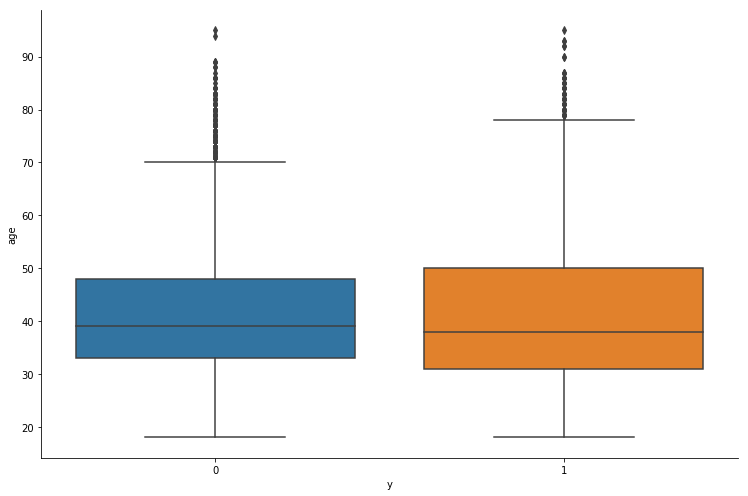

In [80]:
sns.factorplot(kind='box',
               x='y',
               y='age',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

# Análisis de variables categóricas

# Selección del conjunto de datos final

Borrar variables **age**, **day**, **campaign**

In [17]:
df_dummies = pd.get_dummies(df)

In [18]:
df_dummies.shape

(45211, 49)

# Separación de datos de entrenamiento y prueba

In [10]:
from sklearn.model_selection import train_test_split

In [21]:
df_X = df_dummies.loc[:, df_dummies.columns != 'y'].copy()
df_y = df_dummies.y.copy()

TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = TEST_SIZE, random_state = 42)

In [22]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (31647, 48)
X_test:  (13564, 48)
y_train: (31647,)
y_test:  (13564,)


# K-Nearest Neighbors Classifier

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
scaler = StandardScaler()
knn_class = KNeighborsClassifier()

scaler_step = ('scaler', scaler)
knn_class_step = ('knn', knn_class)
steps = [scaler_step, knn_class_step]
pipe = Pipeline(steps)

params = {'knn__n_neighbors': range(2, 10),
          'knn__weights': ['uniform', 'distance'],
          'knn__algorithm': ['auto', 'kd_tree'],
          'knn__p': [1, 2]} # distance metric

kfold = StratifiedKFold(n_splits = 5)

gs_knn_class = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1)
gs_knn_class.fit(X_train, y_train)

y_pred_gs_knn_class = gs_knn_class.predict(X_test)
y_pred_gs_knn_class_proba = gs_knn_class.predict_proba(X_test)

print("Best params: ", gs_knn_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_gs_knn_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_gs_knn_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_gs_knn_class))
print("Precision:", precision_score(y_test, y_pred_gs_knn_class))
print("Recall:", recall_score(y_test, y_pred_gs_knn_class))
print("F1:", f1_score(y_test, y_pred_gs_knn_class))

KeyboardInterrupt: 

# Regresión logística

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
scaler = StandardScaler()
class_LR = LogisticRegression()

scaler_step = ('scaler', scaler)
class_LR_step = ('class_LR', class_LR)
steps = [scaler_step, class_LR_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

y_pred_LR = pipe.predict(X_test)
y_pred_LR_proba = pipe.predict_proba(X_test)

print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_LR_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_LR, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_LR))
print("Precision:", precision_score(y_test, y_pred_LR))
print("Recall:", recall_score(y_test, y_pred_LR))
print("F1:", f1_score(y_test, y_pred_LR))
print('\n')
print("Log loss:", log_loss(y_test, y_pred_LR_proba[:, 1]))

ROC Curve: 0.97


Confusion matrix: 
 [[  95   18]
 [   1 1955]]


Accuracy: 0.99081681972
Precision: 0.989583333333
Recall: 0.840707964602
F1: 0.909090909091


Log loss: 0.0441987943402


# Árbol de decisión

In [19]:
from sklearn.tree import DecisionTreeClassifier

### 6.1 Árbol de decisión básico <a class="anchor" id="arbol-decision-basico"></a>

Creamos un modelo con un árbol de decisión sin modificar ningún parámetro:

In [20]:
scaler = StandardScaler()
class_DT = DecisionTreeClassifier()

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)
steps = [scaler_step, class_DT_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

y_pred_class_DT = pipe.predict(X_test)
y_pred_class_DT_proba = pipe.predict_proba(X_test)

print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_class_DT_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_class_DT, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_class_DT))
print("Precision:", precision_score(y_test, y_pred_class_DT))
print("Recall:", recall_score(y_test, y_pred_class_DT))
print("F1:", f1_score(y_test, y_pred_class_DT))

ROC Curve: 0.91


Confusion matrix: 
 [[  95   18]
 [  23 1933]]


Accuracy: 0.980183663606
Precision: 0.805084745763
Recall: 0.840707964602
F1: 0.822510822511


### 6.2 Árbol de decisión mediante GridSearchCV <a class="anchor" id="arbol-decision-gs"></a>

Para ver si mejora un modelo basado en árboles de decisión, utilizamos la función de **GridSearchCV** para modificar los parámetros.

In [21]:
scaler = StandardScaler()
class_DT = DecisionTreeClassifier()

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)

steps = [scaler_step, class_DT_step]

pipe = Pipeline(steps)

params = {'class_DT__max_depth': range(1, 8),
          'class_DT__min_samples_split': range(2, 10),
          'class_DT__min_samples_leaf': range(2, 10),
          'class_DT__criterion': ['gini', 'entropy']}

kfold = StratifiedKFold(n_splits = 5)

gs_class_DT = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1)
gs_class_DT.fit(X_train, y_train)

y_pred_gs_class_DT = gs_class_DT.predict(X_test)
y_pred_gs_class_DT_proba = gs_class_DT.predict_proba(X_test)

print("Best params: ", gs_class_DT.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_gs_class_DT_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_gs_class_DT, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_gs_class_DT))
print("Precision:", precision_score(y_test, y_pred_gs_class_DT))
print("Recall:", recall_score(y_test, y_pred_gs_class_DT))
print("F1:", f1_score(y_test, y_pred_gs_class_DT))

Best params:  {'class_DT__max_depth': 3, 'class_DT__criterion': 'entropy', 'class_DT__min_samples_leaf': 2, 'class_DT__min_samples_split': 2}


ROC Curve: 0.95


Confusion matrix: 
 [[  94   19]
 [   3 1953]]


Accuracy: 0.989366843886
Precision: 0.969072164948
Recall: 0.83185840708
F1: 0.895238095238


Observamos que la métrica ROC Curve ha pasado de un 0.92 a un 0.95, usando una profundidad de 3, lo que quiere decir que usa pocas variables para crear el árbol.

### 6.3 Visualización de las variables más importantes <a class="anchor" id="arbol-decision-visualizacion"></a>

In [22]:
class_DT = DecisionTreeClassifier(max_depth = gs_class_DT.best_params_['class_DT__max_depth'],
                                  min_samples_leaf = gs_class_DT.best_params_['class_DT__min_samples_leaf'],
                                  min_samples_split = gs_class_DT.best_params_['class_DT__min_samples_split'],
                                  criterion = gs_class_DT.best_params_['class_DT__criterion'])
class_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

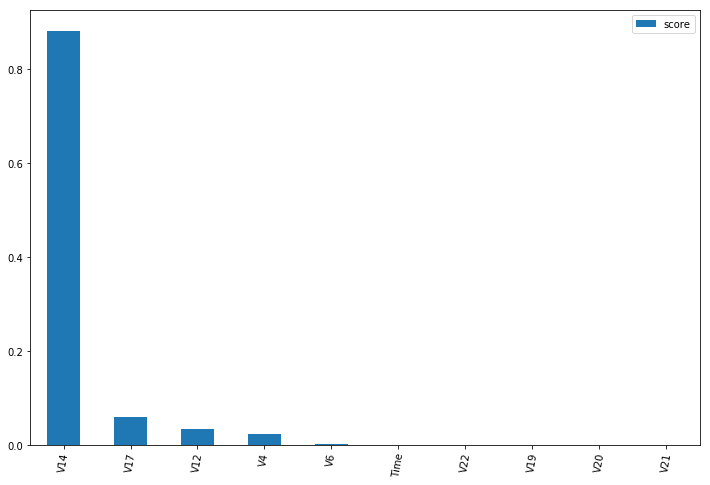

In [23]:
feat = pd.DataFrame(index=X_train.keys(), data=class_DT.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat[:10].plot(kind='bar', rot=80)

Como hemos dicho anteriormente, este modelo usa pocas variables para crear el árbol. En concreto usa 5, teniendo como la más importante **V14**.

### 6.4 Visualización del árbol final <a class="anchor" id="arbol-decision-final"></a>

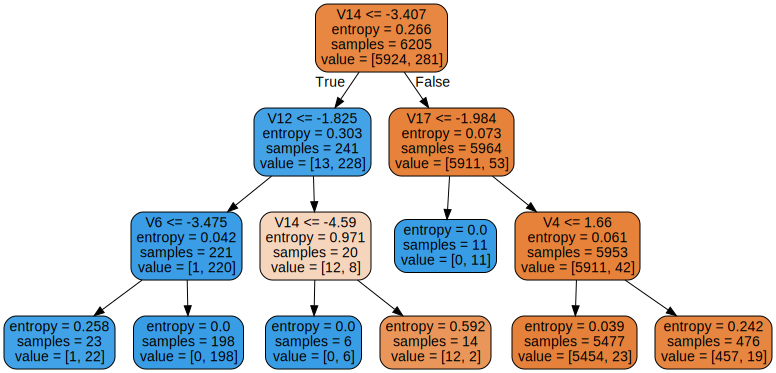

In [24]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(class_DT, 
                                  out_file=None, 
                                  feature_names=X_train.columns,
                                  filled=True,
                                  rounded=True)
graphviz.Source(tree_graph)

# Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

**Random Forest** provee una mejora sobre los árboles de decisión para reducir la varianza. Esto se hace de modo que cada vez que se hace una división en un árbol, se considera una selección aleatoria de m predictores elegidos como candidatos de división de todo el conjunto de p predictores.

Normalmente se usa $m = \sqrt{p}$, lo cual se refleja en el siguiente algoritmo mediante el parámetro *max_features = 'sqrt'*, aunque también se busca si con *max_features = 'auto'*, que es $m = p$ mejora el resultado. Además, con el parámetro n_estimators indicamos el número de árboles que se generan y con max_depth la profundidad de cada árbol. Estimamos la mejor combinación de estos parámetros mediante **GridSearchCV**.

In [26]:
scaler = StandardScaler()
rand_for_class = RandomForestClassifier()

scaler_step = ('scaler', scaler)
rand_for_class_step = ('rand_for_class', rand_for_class)
steps = [scaler_step, rand_for_class_step]
pipe = Pipeline(steps)

tuned_parameters = {'rand_for_class__n_estimators': range(15, 30, 2),
                    'rand_for_class__max_features': ['sqrt', 'auto'],
                    'rand_for_class__max_depth': range(8, 25)}

kfold = StratifiedKFold(n_splits = 5)

gs_rand_for_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_rand_for_class.fit(X_train, y_train)

y_pred_rand_for_class = gs_rand_for_class.predict(X_test)
y_pred_rand_for_class_proba = gs_rand_for_class.predict_proba(X_test)

print("Best params: ", gs_rand_for_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_rand_for_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_rand_for_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_rand_for_class))
print("Precision:", precision_score(y_test, y_pred_rand_for_class))
print("Recall:", recall_score(y_test, y_pred_rand_for_class))
print("F1:", f1_score(y_test, y_pred_rand_for_class))

Best params:  {'rand_for_class__n_estimators': 17, 'rand_for_class__max_depth': 10, 'rand_for_class__max_features': 'sqrt'}


ROC Curve: 0.97


Confusion matrix: 
 [[  94   19]
 [   2 1954]]


Accuracy: 0.989850169164
Precision: 0.979166666667
Recall: 0.83185840708
F1: 0.8995215311


### 7.1 Visualización de las variables más importantes <a class="anchor" id="random-forest-visualizacion"></a>

In [27]:
rand_for_class = RandomForestClassifier(
                    n_estimators = gs_rand_for_class.best_params_['rand_for_class__n_estimators'],
                    max_features = gs_rand_for_class.best_params_['rand_for_class__max_features'],
                    max_depth = gs_rand_for_class.best_params_['rand_for_class__max_depth'])
rand_for_class.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

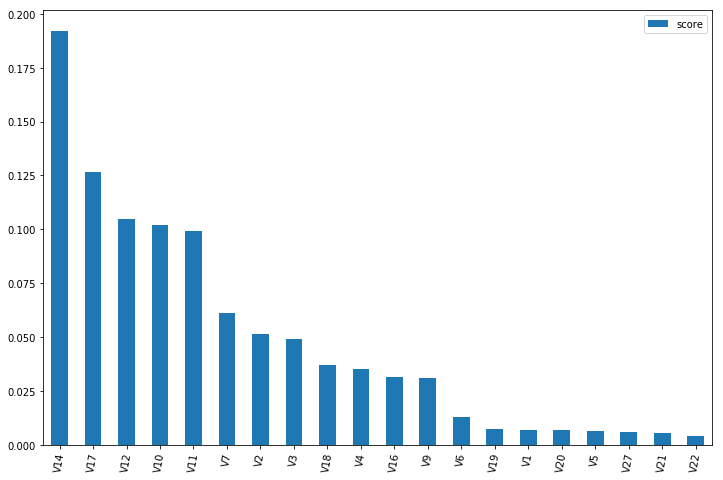

In [28]:
feat = pd.DataFrame(index=X_train.keys(), data=rand_for_class.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat[:20].plot(kind='bar', rot=80)

***

Observamos que los modelos de **Regresión Logística**, **Árbol de decisión** y **Random Forest** nos dan resultados parecidos. No obstante, como ya hemos dicho, **Random Forest** provee una mejora sobre los árboles de decisión para reducir la varianza, por lo que en los próximos modelos, en los que se ha usado **Resampling**, vamos a usar **Random Forest**.